# Used Car Prices

### Problem Statement

The aim of this project is to create regression model to help the new car trader company determine the price of used cars.

### Evaluation Metric
Mean squared error (𝑀𝑆𝐸)

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, RidgeCV, LassoCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
import pickle

# Set matplotlib options
%matplotlib inline
color = '#1F77B4'    # Color is used in barcharts
fontsize=16     # Font size of a  figure title

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 200)


test_data = '2. Prepared Data/public_cars.csv'
prediction_data = '2. Prepared Data/pred_cars.csv'
df = pd.read_csv(test_data)
df_pred = pd.read_csv(prediction_data)

In [2]:
print("The train dataset rows: {} , columns: {} ".format(df.shape[0],df.shape[1]))
print(df.shape)
df.head()

The train dataset rows: 14032 , columns: 26 
(14032, 26)


,manufacturer_name,model_name,transmission,color,odometer_value,year_produced,engine_fuel,engine_has_gas,engine_type,engine_capacity,body_type,has_warranty,state,drivetrain,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,duration_listed,price_usd
0,Ford,Fusion,mechanical,blue,245000,2006,gasoline,False,gasoline,1.6,hatchback,False,owned,front,True,False,False,False,False,False,False,False,False,False,7.0,4250.0
1,Dodge,Caravan,automatic,silver,265542,2002,gasoline,False,gasoline,3.3,minivan,False,owned,front,False,True,False,False,False,False,False,False,False,False,133.0,4000.0
2,Ford,Galaxy,mechanical,blue,168000,2009,diesel,False,diesel,1.8,minivan,False,owned,front,False,False,False,True,False,False,True,True,True,True,0.0,10900.0
3,Mazda,6,mechanical,other,225522,2008,gasoline,False,gasoline,1.8,universal,False,owned,front,False,True,True,False,False,True,False,False,True,True,20.0,6999.0
4,Audi,80,mechanical,black,370000,1991,gasoline,False,gasoline,1.8,sedan,False,owned,front,False,False,False,False,False,False,False,False,False,True,160.0,1600.0


In [3]:
print("The test dataset rows: {} , columns: {} ".format(df_pred.shape[0],df_pred.shape[1]))
print(df_pred.shape)
df_pred.head()

The test dataset rows: 7707 , columns: 25 
(7707, 25)


,manufacturer_name,model_name,transmission,color,odometer_value,year_produced,engine_fuel,engine_has_gas,engine_type,engine_capacity,body_type,has_warranty,state,drivetrain,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,duration_listed
0,Renault,Megane,mechanical,blue,360000,1997,gasoline,False,gasoline,1.6,coupe,False,owned,front,False,True,False,False,False,False,False,True,False,True,114
1,Peugeot,206,mechanical,silver,267000,1999,gasoline,False,gasoline,1.4,hatchback,False,owned,front,False,False,False,False,False,False,False,False,False,True,67
2,Volkswagen,Sharan,mechanical,blue,172000,2000,gasoline,False,gasoline,2.0,minivan,False,owned,front,True,False,False,False,False,False,False,False,False,False,50
3,Volvo,XC60,mechanical,white,230000,2009,diesel,False,diesel,2.4,universal,False,owned,front,False,True,True,True,False,True,True,True,True,True,79
4,Mazda,3,mechanical,silver,206000,2007,gasoline,False,gasoline,1.6,sedan,False,owned,front,False,True,False,True,False,True,False,False,False,False,74


### The Dataset
Each column in the dataset is labeled and explained in more detail below.  

<b>manufacturer_name:</b> the name of the car manufacturer  
<b>model_name:</b> the name of the car model  
<b>transmission:</b> the type of transmission the car has  
<b>color:</b> the body color of the car  
<b>odometer_value:</b> odometer state in kilometers  
<b>year_produced:</b> the year the car was produced  
<b>engine_fuel:</b> the fuel type of the engine of the car  
<b>engine_has_gas:</b> whether or not the car has a propane tank with tubing  
<b>engine_type:</b> the engine type of the car  
<b>engine_capacity:</b> capacity of the engine in liters  
<b>body_type:</b> the of body the car has  
<b>has_warranty:</b> whether the car has warranty  
<b>state:</b> the state of the car (new, owned, etc.)  
<b>drivetrain:</b> type of drivetrain (front, rear, all)  
<b>feature_1 - feature_9:</b> these features are boolean values about properties of the car  
<b>duration_listed:</b> the number of days the car is listed in the catalog  
<b>price_usd:</b> price of the car in USD  

### Dataset Files
public_cars.csv - Dataset to train and analyze  
pred_cars.csv - Dataset to predict cars prices

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14032 entries, 0 to 14031
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   manufacturer_name  14032 non-null  object 
 1   model_name         14032 non-null  object 
 2   transmission       14032 non-null  object 
 3   color              14032 non-null  object 
 4   odometer_value     14032 non-null  int64  
 5   year_produced      14032 non-null  int64  
 6   engine_fuel        14032 non-null  object 
 7   engine_has_gas     14032 non-null  bool   
 8   engine_type        14032 non-null  object 
 9   engine_capacity    14027 non-null  float64
 10  body_type          14032 non-null  object 
 11  has_warranty       14032 non-null  bool   
 12  state              14032 non-null  object 
 13  drivetrain         14031 non-null  object 
 14  feature_0          14031 non-null  object 
 15  feature_1          14031 non-null  object 
 16  feature_2          140

In [5]:
# Find missing values 
print(f'Missing values: {df.isnull().sum()}')

isnull_filter = df['price_usd'].isnull()
df[isnull_filter]

# Drop the row with missing price
missing_price = len(df[isnull_filter].index)
print('\nDropped rows with missing price: {} '.format(missing_price))
df.drop(df[isnull_filter].index, inplace=True)
df = df.reset_index(drop=True)
print('Dataset: {}'.format(df.shape))

# Find missing values 
print('\nMissing values: {}'.format(df.isnull().sum().sum()))

Missing values: manufacturer_name    0
model_name           0
transmission         0
color                0
odometer_value       0
year_produced        0
engine_fuel          0
engine_has_gas       0
engine_type          0
engine_capacity      5
body_type            0
has_warranty         0
state                0
drivetrain           1
feature_0            1
feature_1            1
feature_2            1
feature_3            1
feature_4            1
feature_5            1
feature_6            1
feature_7            1
feature_8            1
feature_9            1
duration_listed      1
price_usd            1
dtype: int64

Dropped rows with missing price: 1 
Dataset: (14031, 26)

Missing values: 5


In [6]:
print(df.isnull().sum())

manufacturer_name    0
model_name           0
transmission         0
color                0
odometer_value       0
year_produced        0
engine_fuel          0
engine_has_gas       0
engine_type          0
engine_capacity      5
body_type            0
has_warranty         0
state                0
drivetrain           0
feature_0            0
feature_1            0
feature_2            0
feature_3            0
feature_4            0
feature_5            0
feature_6            0
feature_7            0
feature_8            0
feature_9            0
duration_listed      0
price_usd            0
dtype: int64


In [7]:
# Split up numeric, categorical, and boolean columns 
print('Columns')
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

#numeric_cols = df.drop('price_usd',axis=1).select_dtypes([np.int64,np.float64]).columns.tolist()
numeric_cols = df.drop('price_usd',axis=1).select_dtypes(numerics).columns.tolist()

#num = len(numeric_cols)
print ('Numeric: {} \n{}'.format(len(numeric_cols),numeric_cols))

categorical_cols = df.select_dtypes([np.object, np.bool]).columns.tolist()
print ('Categorical: {} \n{}'.format(len(categorical_cols),categorical_cols))

booleans_cols = df.select_dtypes([np.bool]).columns.tolist()
print ('Boolean: {} \n{}'.format(len(booleans_cols), booleans_cols))

Columns
Numeric: 4 
['odometer_value', 'year_produced', 'engine_capacity', 'duration_listed']
Categorical: 21 
['manufacturer_name', 'model_name', 'transmission', 'color', 'engine_fuel', 'engine_has_gas', 'engine_type', 'body_type', 'has_warranty', 'state', 'drivetrain', 'feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9']
Boolean: 2 
['engine_has_gas', 'has_warranty']


In [8]:
############################# Utility functions ##########################################
def count_percent(feature, feature_max=0):
    """ Prints count and  percentage for feature or only 10 most common values. """
    value = df[feature].value_counts()
    percentage = (df[feature].value_counts(normalize=True)*100).apply(lambda x: round(x,2))
    df_model = pd.DataFrame({'count':value, 'percentage':percentage})
    df_result = df_model[df_model['count'] > feature_max].sort_values('count', ascending=False)
    
    
    
    print("Frequency distributions for '{}' variable.".format(feature))
    if feature_max!=0:
        print('(top 10 values)')
    print(df_result)

#### Target variable

00.35% percentile: $238.04  - 50 cars
99.35% percentile: $36087.20 - 92 cars


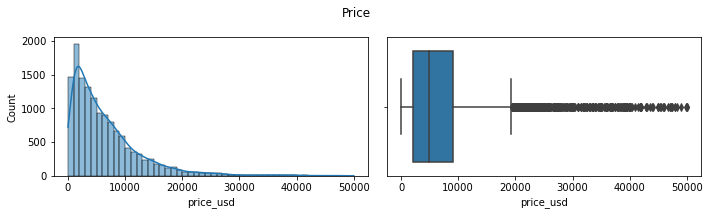

In [9]:
# Plot histograms to show distribution of the target variable
# Plot boxplot to determine “outliers” 
variable = 'price_usd'
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
sns.histplot(data=df, x=variable, kde=True, bins=50, ax=axs[0])
sns.boxplot(data=df, x=variable, ax=axs[1])

fig.suptitle('Price')
plt.tight_layout()

# Identify car price within 3 standard deviations (99.7% of observations)
quantile_left = df['price_usd'].quantile(0.0035)
quantile_right = df['price_usd'].quantile(0.9935)

low_price = len(df[df['price_usd']<quantile_left])
high_price = len(df[df['price_usd']>quantile_right])

print('00.35% percentile: ${:.2f}  - {} cars'.format(quantile_left, low_price))
print('99.35% percentile: ${:.2f} - {} cars'.format(quantile_right, high_price))

In [10]:
df['price_usd'].describe()

count    14031.000000
mean      6617.332204
std       6362.497453
min          1.000000
25%       2100.000000
50%       4800.000000
75%       8999.000000
max      50000.000000
Name: price_usd, dtype: float64

In [11]:
# Round car price to hundreds
df['price_round']=df['price_usd'].apply(lambda x: round(x, -2))

# Create categories of car price
# Split prices into groups with step $500
price_range=range(0,50500, 500)           # range
price_labels=range(500,50500, 500)        # labels
print("Price segments: {}".format(len(price_range)))
df['price_range']=pd.cut(df['price_usd'],price_range,labels=price_labels)

Price segments: 101


#### Predictor variables

#### Numeric variables

<AxesSubplot:xlabel='duration_listed', ylabel='Count'>

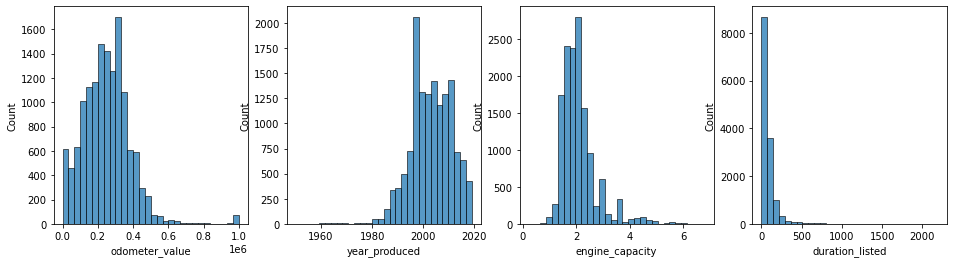

In [12]:
fig, axs = plt.subplots(1,4,figsize=(16,4))
sns.histplot(data=df, x='odometer_value', bins=30, ax=axs[0])
sns.histplot(data=df, x='year_produced', bins=30, ax=axs[1])
sns.histplot(data=df, x="engine_capacity", bins=30,ax=axs[2])
sns.histplot(data=df, x="duration_listed", bins=30,ax=axs[3])

<AxesSubplot:xlabel='duration_listed'>

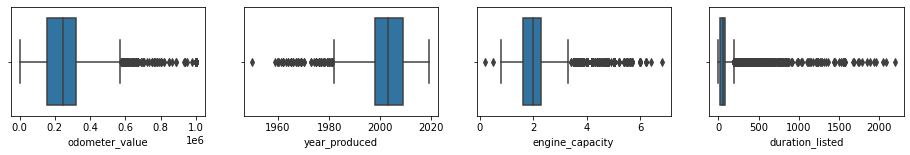

In [13]:
fig, axs = plt.subplots(1,4,figsize=(16,2))
sns.boxplot(data=df, x='odometer_value', ax=axs[0])
sns.boxplot(data=df, x='year_produced', ax=axs[1])
sns.boxplot(data=df, x="engine_capacity", ax=axs[2])
sns.boxplot(data=df, x="duration_listed", ax=axs[3])

In [14]:
df[numeric_cols].describe()

,odometer_value,year_produced,engine_capacity,duration_listed
count,14031.000000,14031.000000,14026.000000,14031.000000
mean,247348.229135,2002.940418,2.057607,81.795453
std,134281.481050,8.097703,0.671651,120.959542
min,0.000000,1950.000000,0.200000,0.000000
25%,156000.000000,1998.000000,1.600000,23.000000
50%,248000.000000,2003.000000,2.000000,59.000000
75%,322332.000000,2009.000000,2.300000,90.000000
max,1000000.000000,2019.000000,6.800000,2189.000000


#### Categorical variables

In [15]:
# Create sets of features
categorical_general = ['manufacturer_name', 'model_name', 'color', 'body_type'] 
categorical_main = ['transmission','has_warranty', 'state', 'drivetrain']
categorical_engine = ['engine_fuel', 'engine_has_gas', 'engine_type']
categorical_features = ['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5',
                    'feature_6', 'feature_7', 'feature_8', 'feature_9']

In [16]:
df[categorical_general].describe()

,manufacturer_name,model_name,color,body_type
count,14031,14031,14031,14031
unique,55,928,12,12
top,Volkswagen,Passat,black,sedan
freq,1540,515,2766,4746


Unique manufacturers:  55
Frequency distributions for 'manufacturer_name' variable.
               count  percentage
Volkswagen      1540       10.98
Opel             987        7.03
Ford             954        6.80
BMW              896        6.39
Audi             888        6.33
Renault          876        6.24
Mercedes-Benz    834        5.94
Peugeot          680        4.85
Citroen          580        4.13
Mazda            510        3.63
Nissan           470        3.35
Toyota           470        3.35
Skoda            419        2.99
Hyundai          405        2.89
Kia              337        2.40
Mitsubishi       327        2.33
Fiat             315        2.25
Honda            309        2.20
Volvo            286        2.04
ВАЗ              169        1.20
Chrysler         162        1.15
Chevrolet        133        0.95
Dodge            125        0.89
Subaru           101        0.72
Seat              97        0.69
Rover             94        0.67
Suzuki            86     

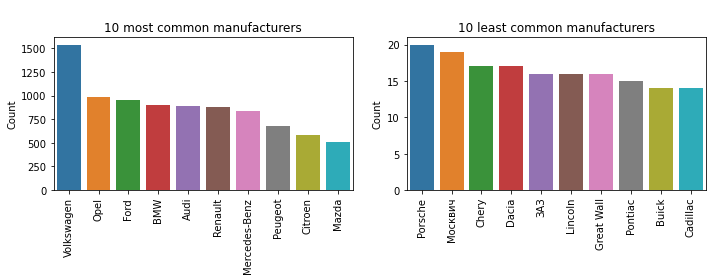

In [17]:
# Find out unique manufactures
manufacturers = df['manufacturer_name'].unique()
print('Unique manufacturers:  {}'.format(len(manufacturers)))
#print(manufacturers)

count_percent('manufacturer_name')

# Find out the most common and the least common car manufactures
df_manufacturers = pd.DataFrame(df['manufacturer_name'].value_counts()).reset_index()
df_manufacturers.columns=['Manufacturer', 'Count']

fig, axs = plt.subplots(1,2,figsize=(10,4))
x_df = df_manufacturers[:10]
sns.barplot(x='Manufacturer', y='Count', data=x_df, ax=axs[0])

x_df= df_manufacturers[len(df_manufacturers)-10:]
sns.barplot(x='Manufacturer', y='Count', data=x_df, ax=axs[1])

axs[0].xaxis.set_tick_params(rotation=90)
axs[1].xaxis.set_tick_params(rotation=90)

axs[0].set_title('\n10 most common manufacturers')
axs[1].set_title('\n10 least common manufacturers')

axs[0].set_xlabel('')
axs[1].set_xlabel('')

plt.tight_layout()

Unique models:  928
Frequency distributions for 'name' variable.
(top 10 values)
                   count  percentage
Volkswagen Passat    515        3.67
Volkswagen Golf      278        1.98
Opel Astra           271        1.93
Audi A6              241        1.72
Ford Mondeo          224        1.60
Opel Vectra          220        1.57
Renault Laguna       198        1.41
Audi A4              187        1.33
Peugeot 406          165        1.18
Skoda Octavia        146        1.04


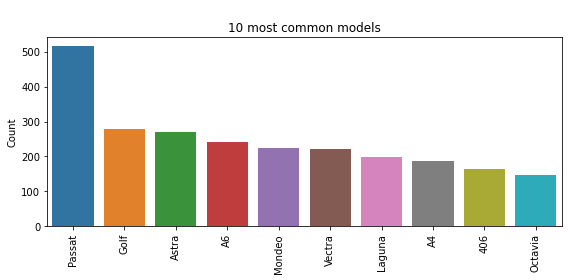

In [18]:
# Find out unique model names
models = df['model_name'].unique()
print('Unique models:  {}'.format(len(models)))
#print(models)

# Find out the most common and the least common car manufactures
df_models = pd.DataFrame(df['model_name'].value_counts()).reset_index()
df_models.columns=['Model', 'Count']

# Create bar plots of categorical variables
fig, ax1 = plt.subplots(ncols=1,nrows=1,figsize=(8,4))
x_df = df_models[:10]
sns.barplot(x='Model', y='Count', data=x_df, ax=ax1)
ax1.xaxis.set_tick_params(rotation=90)
ax1.set_title('\n10 most common models')
ax1.set_xlabel('')

plt.tight_layout()

# Combine manufacturer and model names 
df['name'] = df['manufacturer_name'].apply(lambda x: x.strip()) + ' ' + df['model_name'].apply(lambda x: x.strip())
# Find out number and percentage of models
count_percent('name', 140)

Frequency distributions for 'color' variable.
        count  percentage
black    2766       19.71
silver   2525       18.00
blue     2077       14.80
white    1578       11.25
grey     1373        9.79
red      1062        7.57
green    1024        7.30
other     962        6.86
brown     325        2.32
violet    169        1.20
yellow    114        0.81
orange     56        0.40


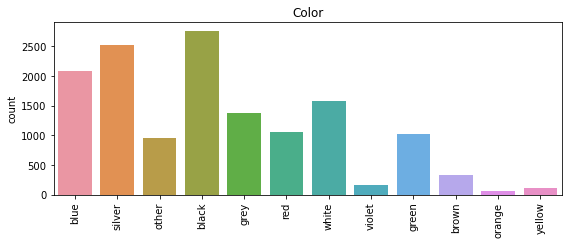

In [19]:
# Print frequency distributions
count_percent('color')
# Create bar plots of categorical variables
fig, ax = plt.subplots(1,1,figsize=(8,3.5))
sns.countplot(x='color',data=df)
ax.xaxis.set_tick_params(rotation=90)
ax.set_title('Color')
ax.set_xlabel('')
plt.tight_layout()

In [20]:
################## Reduce a number of categories ############################
# Add 'hybrid-diesel' to 'diesel' category
df['color']=df['color'].replace({'violet':'other','yellow':'other','orange':'other', 'brown':'other'})

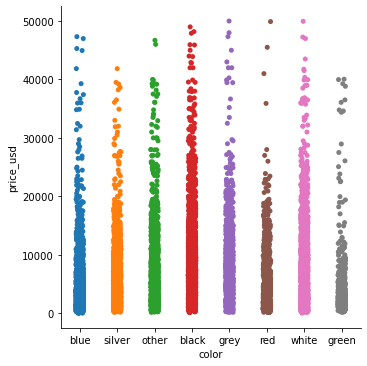

In [21]:
sns.catplot(x='color',y='price_usd',data=df)

Frequency distributions for 'body_type' variable.
           count  percentage
sedan       4746       33.83
hatchback   2799       19.95
universal   1963       13.99
suv         1903       13.56
minivan     1287        9.17
minibus      517        3.68
van          275        1.96
coupe        241        1.72
liftback     216        1.54
pickup        50        0.36
cabriolet     26        0.19
limousine      8        0.06


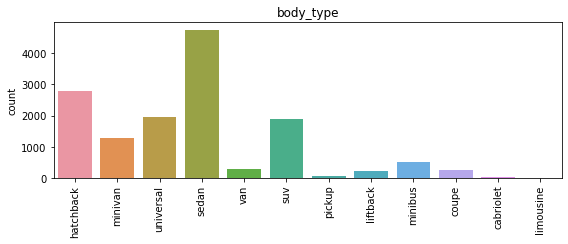

In [22]:
# Print frequency distributions
count_percent('body_type')
# Create bar plots of categorical variables
fig, ax = plt.subplots(1,1,figsize=(8,3.5))
sns.countplot(x='body_type',data=df)
ax.xaxis.set_tick_params(rotation=90)
ax.set_title('body_type')
ax.set_xlabel('')
plt.tight_layout()

In [23]:
################## Reduce a number of categories ############################
# Add 'hybrid-diesel' to 'diesel' category
df['body_type']=df['body_type'].replace({'pickup':'other','cabriolet':'other','limousine':'other'})

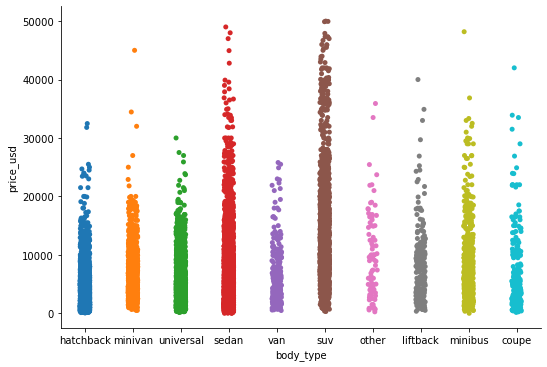

In [24]:
sns.catplot(x='body_type',y='price_usd',data=df, aspect=1.5)

Frequency distributions for 'transmission' variable.
            count  percentage
mechanical   9289        66.2
automatic    4742        33.8
Frequency distributions for 'drivetrain' variable.
       count  percentage
front  10094       71.94
all     1980       14.11
rear    1957       13.95


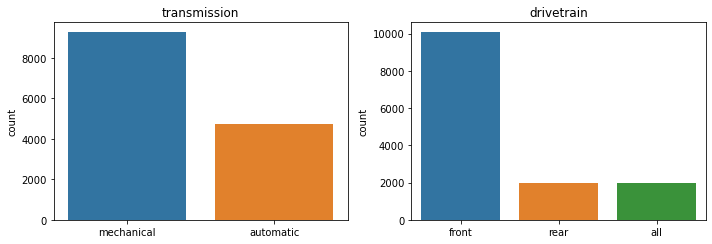

In [25]:
# Print frequency distributions
count_percent('transmission')
count_percent('drivetrain')
# Create bar plots of categorical variables
fig, axs = plt.subplots(1,2,figsize=(10,3.5))
sns.countplot(x='transmission', data=df, ax=axs[0])
sns.countplot(x='drivetrain', data=df, ax=axs[1])

axs[0].set_title('transmission')
axs[0].set_xlabel('')
axs[1].set_title('drivetrain')
axs[1].set_xlabel('')
plt.tight_layout()

Frequency distributions for 'has_warranty' variable.
       count  percentage
False  13869       98.85
True     162        1.15
Frequency distributions for 'state' variable.
           count  percentage
owned      13726       97.83
new          168        1.20
emergency    137        0.98


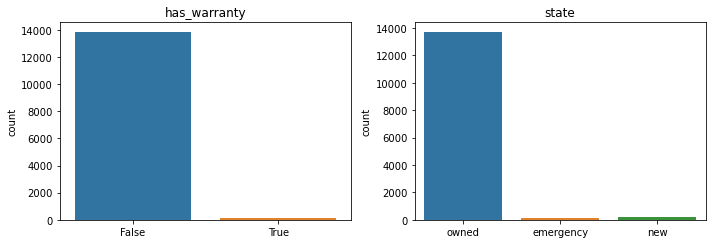

In [26]:
# Print frequency distributions
count_percent('has_warranty')
count_percent('state')
# Create bar plots of categorical variables
fig, axs = plt.subplots(1,2,figsize=(10,3.5))
sns.countplot(x='has_warranty', data=df, ax=axs[0])
sns.countplot(x='state', data=df, ax=axs[1])

axs[0].set_title('has_warranty')
axs[0].set_xlabel('')
axs[1].set_title('state')
axs[1].set_xlabel('')
plt.tight_layout()

In [27]:
# Count unique values
categorical_engine = ['engine_fuel', 'engine_type']
for column in categorical_engine:
    print(pd.DataFrame(df[column].value_counts()))

               engine_fuel
gasoline              8801
diesel                4629
gas                    505
hybrid-petrol           90
electric                 5
hybrid-diesel            1
          engine_type
gasoline         9396
diesel           4630
electric            5


In [28]:
################## Reduce a number of categories ############################
# Add 'hybrid-diesel' to 'diesel' category
df['engine_fuel']=df['engine_fuel'].replace({'hybrid-diesel':'diesel'})

Frequency distributions for 'engine_fuel' variable.
               count  percentage
gasoline        8801       62.73
diesel          4630       33.00
gas              505        3.60
hybrid-petrol     90        0.64
electric           5        0.04
Frequency distributions for 'engine_type' variable.
          count  percentage
gasoline   9396       66.97
diesel     4630       33.00
electric      5        0.04

505 car has a propane tank (use gas)


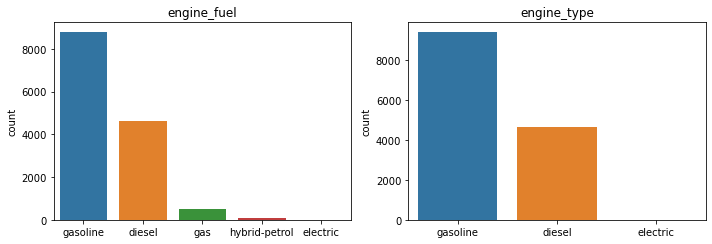

In [29]:
# Print frequency distributions
count_percent('engine_fuel')
count_percent('engine_type')

fig, axes = plt.subplots(ncols=len(categorical_engine),nrows=1,figsize=(10,3.5))
for index,column in enumerate(categorical_engine):
    sns.countplot(x=column, data=df, ax=axes[index])
    axes[index].set_title(column)
    axes[index].set_xlabel('')
plt.tight_layout()

# Check that number of observations with condition:
# 'engine_has_gas'==True and 'engine_fuel'=='gas' is 505.
mask_gas = (df['engine_has_gas'] ==True) & (df['engine_fuel']=='gas')
gas=len(df[mask_gas])
print('\n{} car has a propane tank (use gas)'.format(gas))

Frequency distributions for 'engine_type' variable.
          count  percentage
gasoline   9396       66.97
diesel     4630       33.00
electric      5        0.04


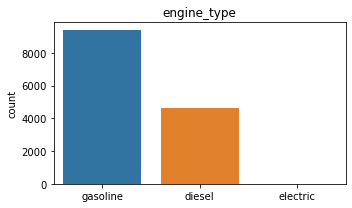

In [30]:
# Print frequency distributions
count_percent('engine_type')
# Create bar plots of categorical variables
fig, ax = plt.subplots(1,1,figsize=(5,3))
sns.countplot(x='engine_type',data=df)
ax.set_title('engine_type')
ax.set_xlabel('')
plt.tight_layout()

Frequency distributions for 'feature_0' variable.
       count  percentage
False  10802       76.99
True    3229       23.01
Frequency distributions for 'feature_1' variable.
       count  percentage
True    8507       60.63
False   5524       39.37
Frequency distributions for 'feature_2' variable.
       count  percentage
False  10852       77.34
True    3179       22.66
Frequency distributions for 'feature_3' variable.
       count  percentage
False  10139       72.26
True    3892       27.74
Frequency distributions for 'feature_4' variable.
       count  percentage
False  10650        75.9
True    3381        24.1
Frequency distributions for 'feature_5' variable.
       count  percentage
False   9095       64.82
True    4936       35.18
Frequency distributions for 'feature_6' variable.
       count  percentage
False  11663       83.12
True    2368       16.88
Frequency distributions for 'feature_7' variable.
       count  percentage
False  10390       74.05
True    3641       25.95


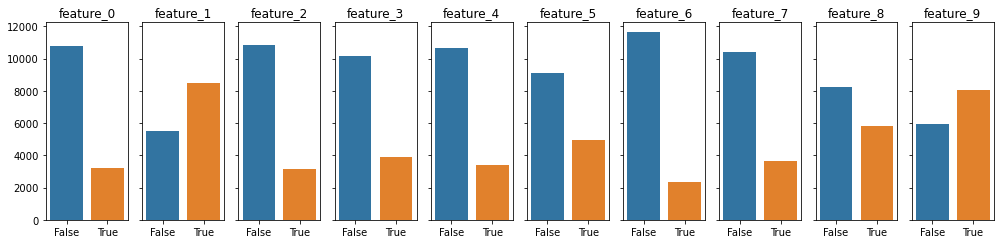

In [31]:
# Print frequency distributions
for feature in categorical_features:
    count_percent(feature)

fig, axes = plt.subplots(ncols=len(categorical_features),nrows=1,figsize=(14,3.5), sharey=True)
for index,column in enumerate(categorical_features):
    sns.countplot(x=column, data=df, ax=axes[index])
    axes[index].set_title(column)
    axes[index].set_xlabel('')
    axes[index].set_ylabel('')
plt.tight_layout()

In [32]:
# Count a total number of unnamed features for a car
df['other_features']=df[categorical_features].sum(axis=1).astype(int)

In [33]:
# Convert boolean values to numeric 
for feature in categorical_features:
    df[feature]=df[feature].astype(int)

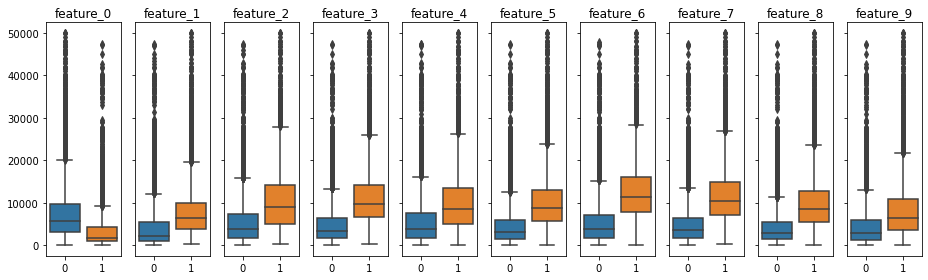

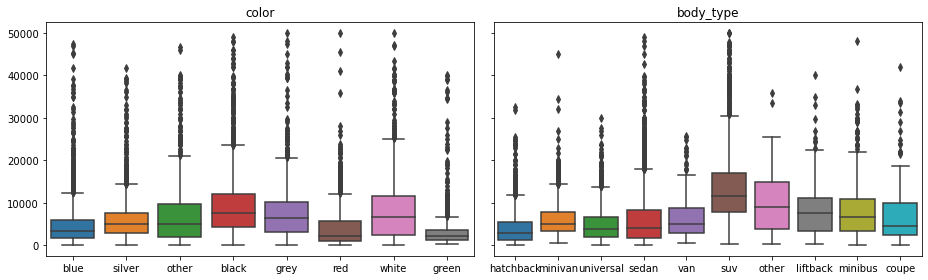

In [34]:
# Create box plots of categorical variables
fig, axes = plt.subplots(ncols=len(categorical_features), nrows=1, figsize=(13,4), sharey=True )
for index,column in enumerate(categorical_features):
    sns.boxplot(x=column,y='price_usd',data=df, ax=axes[index])
    axes[index].set_title(column)
    axes[index].set_xlabel('')
    axes[index].set_ylabel('')
        
plt.tight_layout()
categorical_general=['color','body_type']
fig, axes = plt.subplots(ncols=len(categorical_general), nrows=1, figsize=(13,4), sharey=True )
for index,column in enumerate(categorical_general):
    sns.boxplot(x=column,y='price_usd',data=df, ax=axes[index])
    axes[index].set_title(column)
    axes[index].set_xlabel('')
    axes[index].set_ylabel('')
        
plt.tight_layout()

In [35]:
manufacturer_df=pd.crosstab(df['price_range'], df['manufacturer_name']).sort_values(by='price_range', ascending=False)
manufacturer_df=pd.DataFrame(manufacturer_df)

Text(0.5, 0, '')

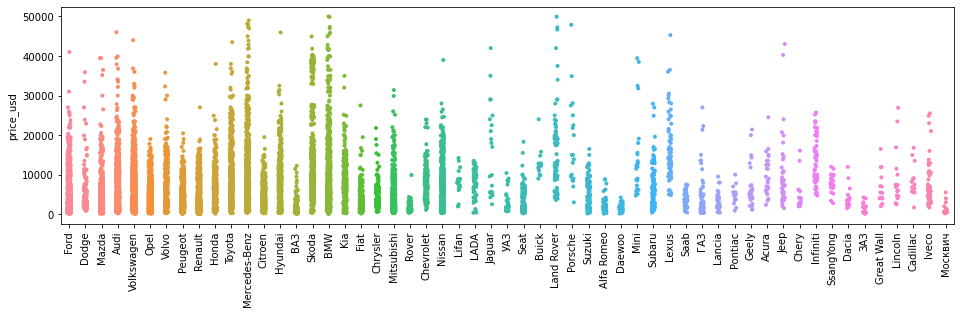

In [36]:
fig, ax = plt.subplots(figsize=(16,4))
sns.stripplot(x='manufacturer_name',y='price_usd',data=df, size=4, ax=ax)
ax.xaxis.set_tick_params(rotation=90)
ax.set_xlabel('')

Text(0.5, 78.0, '')

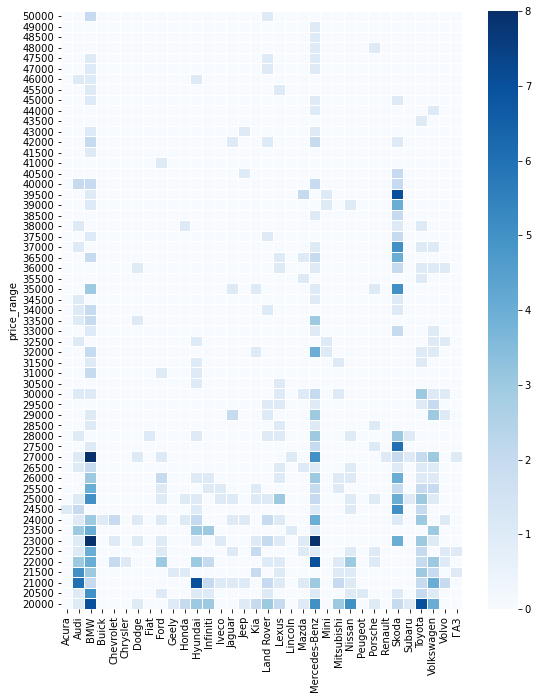

In [37]:
fig, ax = plt.subplots(figsize=(9,11))
df_1=manufacturer_df.loc[:20000]

df_sum=df_1.sum()
df_1=df_1[list(df_sum[df_sum>0].index)]

sns.heatmap(df_1, cmap='Blues', linewidths=0.01)
ax.set_xlabel('')

Text(0.5, -3.0, '')

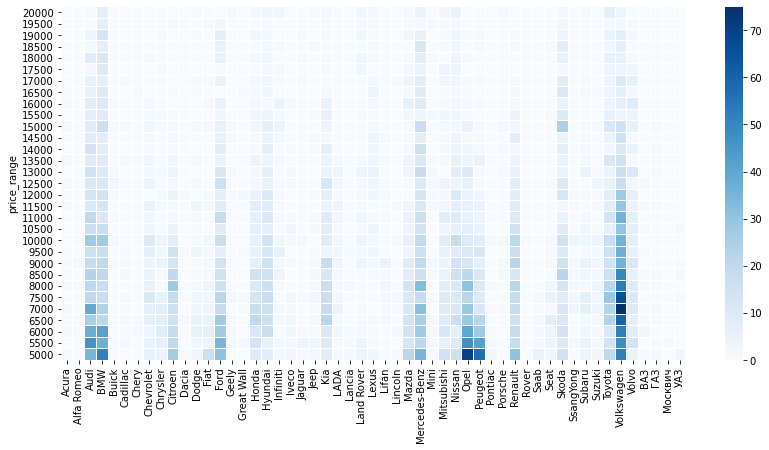

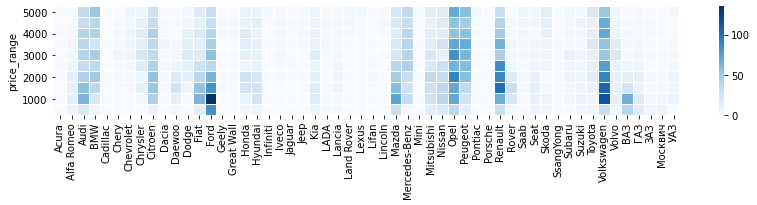

In [38]:
fig, ax = plt.subplots(figsize=(14,6.5))
df_1=manufacturer_df.loc[20000:5000]

df_sum=df_1.sum()
df_1=df_1[list(df_sum[df_sum>0].index)]

sns.heatmap(df_1, cmap='Blues', linewidths=0.01)
ax.set_xlabel('')

fig, ax = plt.subplots(figsize=(14,2))
df_1=manufacturer_df.loc[5000:]

df_sum=df_1.sum()
df_1=df_1[list(df_sum[df_sum>0].index)]

sns.heatmap(df_1, cmap='Blues', linewidths=0.01)
ax.set_xlabel('')

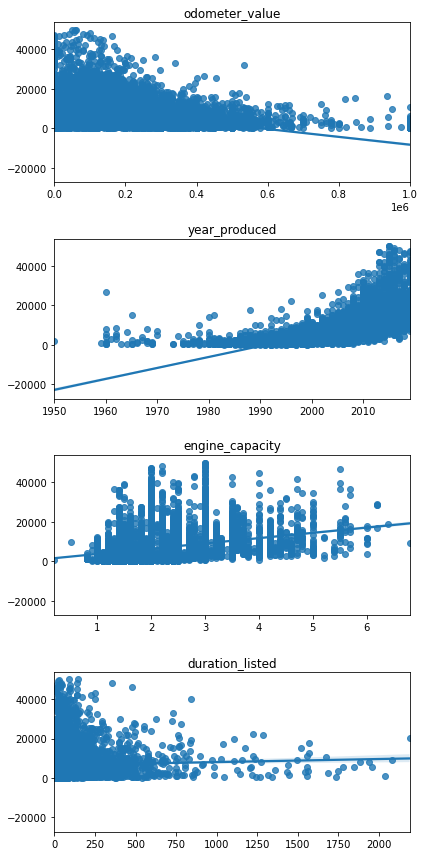

In [39]:
# Check relationship between numerical variables and car price
fig, axes = plt.subplots(nrows=4,ncols=1,figsize=(6,12), sharey=True)
for index,column in enumerate(numeric_cols):
    sns.regplot(x=column,y='price_usd',data=df, ax=axes[index])
    axes[index].set_title(column)
    axes[index].set_xlabel('')
    axes[index].set_ylabel('')

plt.tight_layout()

In [40]:
# Numerical features
mask1=(df['odometer_value'] > 250000) & (df['price_usd']>30000)
mask2=(df['year_produced'] < 1955) 
mask3=(df['year_produced'] < 1970) & (df['price_usd']>10000)
mask4=(df['engine_capacity'] < 0.8)

# Combine all filters
outliers = df[mask1|mask2|mask3|mask4]
#outliers

# Save the rows with extreme outliers to csv file
fl = "4. Analysis/used_car_prices_extreme_outliers.csv"
#outliers.to_csv(fl, index=False)
       
print("Dataset: {}".format(df.shape))
df.drop(outliers.index, inplace=True )
df.reset_index(drop=True)
print('Drop {} outliers'.format(len(outliers)))
print("Dataset: {}".format(df.shape))       

Dataset: (14031, 30)
Drop 8 outliers
Dataset: (14023, 30)


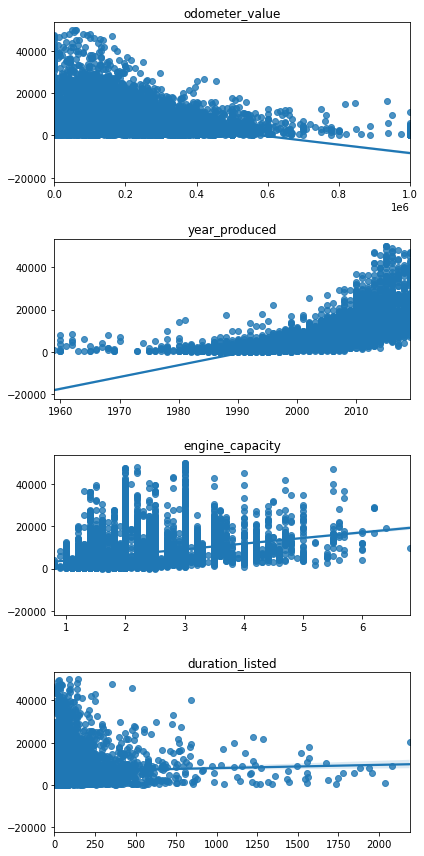

In [41]:
# Check relationship between numerical variables and car price
fig, axes = plt.subplots(nrows=4,ncols=1,figsize=(6,12), sharey=True)
for index,column in enumerate(numeric_cols):
    sns.regplot(x=column,y='price_usd',data=df, ax=axes[index])
    axes[index].set_title(column)
    axes[index].set_xlabel('')
    axes[index].set_ylabel('')

plt.tight_layout()

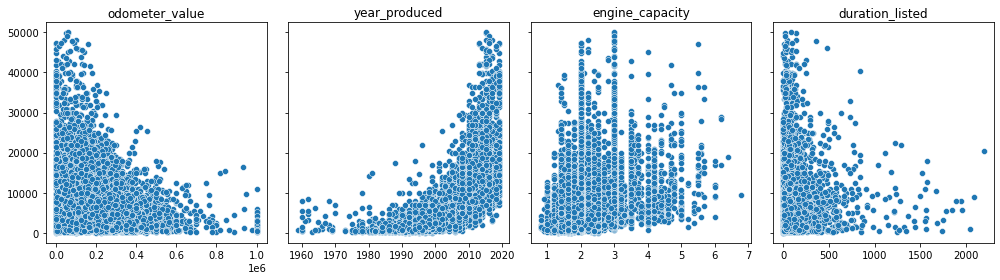

In [42]:
# Check relationship between numerical variables and car price
fig, axes = plt.subplots(nrows=1,ncols=4,figsize=(14,4), sharey=True)
for index,column in enumerate(numeric_cols):
    sns.scatterplot(x=column,y='price_usd',data=df, ax=axes[index])
    axes[index].set_title(column)
    axes[index].set_xlabel('')
    axes[index].set_ylabel('')

plt.tight_layout()

Text(0.5, 1.0, 'Correlation Matrix')

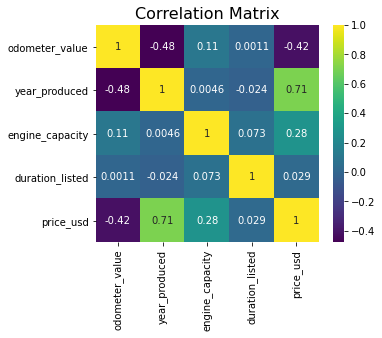

In [43]:
# Check no or little correlation between independent variables
corr = df[numeric_cols + ['price_usd']].corr()

fig, ax = plt.subplots(figsize=(5,4))
ax = sns.heatmap(corr,annot=True,cmap='viridis')
plt.title('Correlation Matrix', fontsize=fontsize) 

In [44]:
# Create a feature that represents mileage per year
df['odometer_value/year'] = round(df['odometer_value']/(2020 - df['year_produced']))
# Create a feature how old is a car
df['year'] = 2020 - df['year_produced']

Text(0.5, 1.0, 'Correlation Matrix')

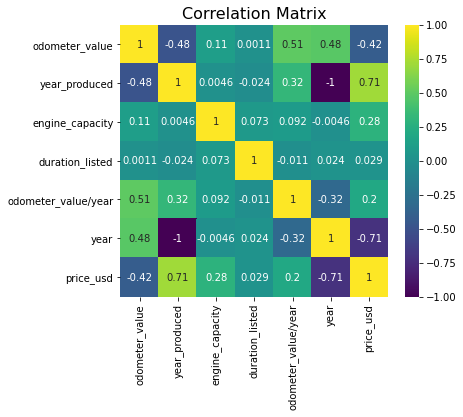

In [45]:
# Check no or little correlation between independent variables
corr = df[numeric_cols + ['odometer_value/year', 'year', 'price_usd']].corr()

fig, ax = plt.subplots(figsize=(6,5))
ax = sns.heatmap(corr,annot=True,cmap='viridis')
plt.title('Correlation Matrix', fontsize=fontsize) 

In [46]:
df.head()

,manufacturer_name,model_name,transmission,color,odometer_value,year_produced,engine_fuel,engine_has_gas,engine_type,engine_capacity,body_type,has_warranty,state,drivetrain,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,duration_listed,price_usd,price_round,price_range,name,other_features,odometer_value/year,year
0,Ford,Fusion,mechanical,blue,245000,2006,gasoline,False,gasoline,1.6,hatchback,False,owned,front,1,0,0,0,0,0,0,0,0,0,7.0,4250.0,4200.0,4500,Ford Fusion,1,17500.0,14
1,Dodge,Caravan,automatic,silver,265542,2002,gasoline,False,gasoline,3.3,minivan,False,owned,front,0,1,0,0,0,0,0,0,0,0,133.0,4000.0,4000.0,4000,Dodge Caravan,1,14752.0,18
2,Ford,Galaxy,mechanical,blue,168000,2009,diesel,False,diesel,1.8,minivan,False,owned,front,0,0,0,1,0,0,1,1,1,1,0.0,10900.0,10900.0,11000,Ford Galaxy,5,15273.0,11
3,Mazda,6,mechanical,other,225522,2008,gasoline,False,gasoline,1.8,universal,False,owned,front,0,1,1,0,0,1,0,0,1,1,20.0,6999.0,7000.0,7000,Mazda 6,5,18794.0,12
4,Audi,80,mechanical,black,370000,1991,gasoline,False,gasoline,1.8,sedan,False,owned,front,0,0,0,0,0,0,0,0,0,1,160.0,1600.0,1600.0,2000,Audi 80,1,12759.0,29


In [47]:
# Create a class to transform columns 
class FeatureEngineering(BaseEstimator, TransformerMixin):
       
    def fit(self, X, y=None):
        return self  
    
    def transform(self, X, y=None):
        df = X
        
        # Create 'name' variable to combine manufacture and model names
        columns_strip = ['manufacturer_name', 'model_name']
        # Delete extra space in strings
        for column in columns_strip:
            df[column] = df[column].apply(lambda x: x.strip())
        # Combine manufacture and model names    
        df['name'] = df['manufacturer_name'] + ' ' + df['model_name']

        # Create a feature that represents mileage per year
        df['odometer_value/year'] = round(df['odometer_value']/(2020 - df['year_produced']))
        # Create a feature how old is a car
        df['year'] = 2020 - df['year_produced']

        # Reduce the number of car model names
        # Set a limit of rare car occurrence
        car_total = 6
        # Count a number of car names and convert the result to a dataframe
        car_models = pd.DataFrame(df['name'].value_counts())
        # Get a list of rare car names
        car_models_list = car_models[car_models['name'] < car_total].index
        # create a new category'other' for rare car model names
        df['name'] = df['name'].apply(lambda x: 'other' if x in car_models_list else x)

        # Create features to reduce a number of categories
        hybrid ='hybrid_or_electric'
        df['engine_fuel'] = df['engine_fuel'].replace({'hybrid-petrol':hybrid,'hybrid-diesel':hybrid,'electric':hybrid})

        # Create a list of unnamed features
        features_list = ['feature_0','feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9']
        # Count a total number of unnamed features for a car
        df['other_features']=df[features_list].sum(axis=1)
        
        global feats
        feats = ['name', 'odometer_value/year', 'year', 'other_features'] 
        
        return X

# Create a pipeline for feature engineering
feature_engineering = Pipeline(steps=
                               [('features', FeatureEngineering())
                               ])

# Create new features using the pipeline
df=feature_engineering.fit_transform(df)

In [48]:
df.head()

,manufacturer_name,model_name,transmission,color,odometer_value,year_produced,engine_fuel,engine_has_gas,engine_type,engine_capacity,body_type,has_warranty,state,drivetrain,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,duration_listed,price_usd,price_round,price_range,name,other_features,odometer_value/year,year
0,Ford,Fusion,mechanical,blue,245000,2006,gasoline,False,gasoline,1.6,hatchback,False,owned,front,1,0,0,0,0,0,0,0,0,0,7.0,4250.0,4200.0,4500,Ford Fusion,1,17500.0,14
1,Dodge,Caravan,automatic,silver,265542,2002,gasoline,False,gasoline,3.3,minivan,False,owned,front,0,1,0,0,0,0,0,0,0,0,133.0,4000.0,4000.0,4000,Dodge Caravan,1,14752.0,18
2,Ford,Galaxy,mechanical,blue,168000,2009,diesel,False,diesel,1.8,minivan,False,owned,front,0,0,0,1,0,0,1,1,1,1,0.0,10900.0,10900.0,11000,Ford Galaxy,5,15273.0,11
3,Mazda,6,mechanical,other,225522,2008,gasoline,False,gasoline,1.8,universal,False,owned,front,0,1,1,0,0,1,0,0,1,1,20.0,6999.0,7000.0,7000,Mazda 6,5,18794.0,12
4,Audi,80,mechanical,black,370000,1991,gasoline,False,gasoline,1.8,sedan,False,owned,front,0,0,0,0,0,0,0,0,0,1,160.0,1600.0,1600.0,2000,Audi 80,1,12759.0,29


In [49]:
df['has_warranty']=df['has_warranty'].astype(int)

In [50]:
# Define predictor and target variables
features =[ 'manufacturer_name', 'model_name', 'has_warranty', 'state', 'drivetrain', 'transmission', 
           'odometer_value', 'odometer_value/year', 'year', 'other_features'
       
           ]

target = 'price_usd'

In [51]:
df['transmission'].value_counts()

mechanical    9282
automatic     4741
Name: transmission, dtype: int64

In [52]:
df[features].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14023 entries, 0 to 14030
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   manufacturer_name    14023 non-null  object 
 1   model_name           14023 non-null  object 
 2   has_warranty         14023 non-null  int32  
 3   state                14023 non-null  object 
 4   drivetrain           14023 non-null  object 
 5   transmission         14023 non-null  object 
 6   odometer_value       14023 non-null  int64  
 7   odometer_value/year  14023 non-null  float64
 8   year                 14023 non-null  int64  
 9   other_features       14023 non-null  int64  
dtypes: float64(1), int32(1), int64(3), object(5)
memory usage: 1.1+ MB


In [53]:
df.head()

,manufacturer_name,model_name,transmission,color,odometer_value,year_produced,engine_fuel,engine_has_gas,engine_type,engine_capacity,body_type,has_warranty,state,drivetrain,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,duration_listed,price_usd,price_round,price_range,name,other_features,odometer_value/year,year
0,Ford,Fusion,mechanical,blue,245000,2006,gasoline,False,gasoline,1.6,hatchback,0,owned,front,1,0,0,0,0,0,0,0,0,0,7.0,4250.0,4200.0,4500,Ford Fusion,1,17500.0,14
1,Dodge,Caravan,automatic,silver,265542,2002,gasoline,False,gasoline,3.3,minivan,0,owned,front,0,1,0,0,0,0,0,0,0,0,133.0,4000.0,4000.0,4000,Dodge Caravan,1,14752.0,18
2,Ford,Galaxy,mechanical,blue,168000,2009,diesel,False,diesel,1.8,minivan,0,owned,front,0,0,0,1,0,0,1,1,1,1,0.0,10900.0,10900.0,11000,Ford Galaxy,5,15273.0,11
3,Mazda,6,mechanical,other,225522,2008,gasoline,False,gasoline,1.8,universal,0,owned,front,0,1,1,0,0,1,0,0,1,1,20.0,6999.0,7000.0,7000,Mazda 6,5,18794.0,12
4,Audi,80,mechanical,black,370000,1991,gasoline,False,gasoline,1.8,sedan,0,owned,front,0,0,0,0,0,0,0,0,0,1,160.0,1600.0,1600.0,2000,Audi 80,1,12759.0,29


In [54]:
from sklearn.preprocessing import OneHotEncoder
encoder_cols = ['manufacturer_name', 'model_name','state', 'drivetrain', 'transmission' ]
enc = OneHotEncoder()

enc.fit(df[encoder_cols])
df_tr = enc.transform(df[encoder_cols]).toarray()

In [55]:
df_tr

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [56]:
transformed = jobs_encoder.transform(data['Profession'].to_numpy().reshape(-1, 1))
#Create a Pandas DataFrame of the hot encoded column
ohe_df = pd.DataFrame(transformed, columns=jobs_encoder.get_feature_names())
#concat with original data
data = pd.concat([data, ohe_df], axis=1).drop(['Profession'], axis=1)

NameError: name 'jobs_encoder' is not defined

In [ ]:
df[encoder_cols] = df_tr

In [ ]:
www
import statsmodels.api as sm
import statsmodels.formula.api as smf
print('OLS regression model for the assosiation between urban and internet use rate')
reg = smf.ols(formula='internetuserate~urbanrate',data=df).fit()
print(reg.summary())